# Análise Exploratória de Dados
## Importando bibliotecas

In [52]:
from src.data import prepare
from src.data import process
from src.data import visualize

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import re
import string

from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud
from PIL import Image

plt.style.use('seaborn-notebook')
%matplotlib inline

## Carregando os dados

In [5]:
true_path = "../data/raw/full_texts/true/"
fake_path = "../data/raw/full_texts/fake/"
output_path = "../data/interim/news.csv"

#prepare.make_text_dataframe(true_path, fake_path, output_path)

## Importando dados pré-processados

In [6]:
news_df = pd.read_csv(output_path)
news_df.sample(10)

,text,label
2435,"Terça-feira, 23 de maio de 2017. Boa noite! Aq...",true
2434,Cristãos transgêneros lutam para conciliar fé ...,true
790,"Nada se compara à tensão do ano passado, diz d...",true
733,"Retrospectiva: Apesar de sanções, Coreia do No...",true
6456,Tudo ou nada! STF julga hoje ação que pode res...,fake
1659,Lista de Janot deve ser entregue nesta terça a...,true
6448,A encomenda de Trump para Kim Jong-un: Uma meg...,fake
7146,Corte no Bolsa Família para 2016 pode jogar 8 ...,fake
1483,Mulher perde bebê aos nove meses de gravidez p...,true
1942,"Prejuízo moral está dado, ninguém vai recuperá...",true


## Pré-Processamento Básico

### Passando as palavras para minúsculo

In [7]:
news_df['clean_text'] = news_df['text'].apply(lambda x: x.lower())
news_df.sample(10)

,text,label,clean_text
1803,"Da pacata St. Lucie, Barbieri mandou quase 1,2...",true,"da pacata st. lucie, barbieri mandou quase 1,2..."
5733,"CORREÇÃO: PF não ""invadiu"" hospital nem centro...",fake,"correção: pf não ""invadiu"" hospital nem centro..."
2868,"Quarta-feira, 13 de setembro de 2017. Boa noit...",true,"quarta-feira, 13 de setembro de 2017. boa noit..."
6625,Deputado transforma Câmara dos Deputados em ig...,fake,deputado transforma câmara dos deputados em ig...
4955,Jovem de 29 anos gasta milhares de dólares par...,fake,jovem de 29 anos gasta milhares de dólares par...
2123,"Sexta-feira, 5 de janeiro de 2018. Boa noite! ...",true,"sexta-feira, 5 de janeiro de 2018. boa noite! ..."
3351,"O grupo BRF , alvo da Operação Trapaça, terce...",true,"o grupo brf , alvo da operação trapaça, terce..."
5144,Maior estatal de serviços do país vai demitir ...,fake,maior estatal de serviços do país vai demitir ...
3534,"Mesmo sem sabor de novidade, O Rei da Vela sur...",true,"mesmo sem sabor de novidade, o rei da vela sur..."
4494,"Assad bate de frente com Trump e declara: "" Nã...",fake,"assad bate de frente com trump e declara: "" nã..."


### Removendo datas
#### Formato dd/mm/YYYY

In [8]:
news_df['clean_text'] = process.remove_date(news_df.clean_text) 

/home/tayna/Downloads/academico/doutorado/projetos/atlantico-bootcamp/fake-news-detector/src/data/process.py:32: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  size = text_series[text_series.str.contains(pattern)].size


Modificando 103 linhas contendo este padrão.


#### Formato dd de mês de YYYY

In [9]:
#remove datas no formato dd de mês de YYYY
news_df['clean_text'] = process.remove_date(news_df.clean_text, style='diamesextensoano')

Modificando 643 linhas contendo este padrão.


#### Dias da semana

In [10]:
# remove dias da semana
news_df['clean_text'] = news_df['clean_text'].apply(lambda c: process.remove_weekday(c))
#news_df['clean_clean_text']
news_df.sample(10)

,text,label,clean_text
4138,Na mão grande? TCU vai fazer auditoria para ap...,fake,na mão grande? tcu vai fazer auditoria para ap...
2854,O que se sabe sobre a capacidade militar da Co...,true,o que se sabe sobre a capacidade militar da co...
5073,"Mainardi avisou: ""Lula já está com um pé na ca...",fake,"mainardi avisou: ""lula já está com um pé na ca..."
4907,"Anônimo escreve obra-prima literária: ""Os erro...",fake,"anônimo escreve obra-prima literária: ""os erro..."
4832,URGENTE: Presidente teria oferecido R$ 1 milhã...,fake,urgente: presidente teria oferecido r$ 1 milhã...
6548,"""Lucro do Facebook é baseado em falsos engajam...",fake,"""lucro do facebook é baseado em falsos engajam..."
1055,O que faz teste nuclear da Coreia do Norte ain...,true,o que faz teste nuclear da coreia do norte ain...
4310,"Professora de direito dá show: ""Temos que tira...",fake,"professora de direito dá show: ""temos que tira..."
5000,"Senador Malta se irrita: ""Os filhos do Lula pa...",fake,"senador malta se irrita: ""os filhos do lula pa..."
393,Funaro diz que Yunes tinha certeza de que esta...,true,funaro diz que yunes tinha certeza de que esta...


### Removendo caracteres especiais
#### '\n'

In [11]:
news_df['clean_text'] = process.remove_linebreaks(news_df.clean_text)

Modificando 577 linhas contendo este padrão.


In [12]:
news_df['clean_text'][news_df['clean_text'].str.contains('\t')]

623     tiririca faz primeiro discurso na câmara para ...
2735     a força-tarefa da operação lava jato pediu em...
6397    kátia abreu diz que vai colocar sua expulsão e...
Name: clean_text, dtype: object

In [13]:
news_df['clean_text'].iloc[[623, 2735, 6397]].str.findall('\t')

623                         [\t]
2735    [\t, \t, \t, \t, \t, \t]
6397                        [\t]
Name: clean_text, dtype: object

In [14]:
news_df['clean_text'] = process.remove_tabs(news_df.clean_text)

Modificando 3 linhas contendo este padrão.


### Removendo pontuação

In [15]:
punctuation = list(string.punctuation) # Obtendo os caracteres especiais como lista
del(punctuation[12]) # Excluindo da remoção o caractere especial "-"
punctuation = "".join(punctuation) # Transformando novamente em string
punctuation

'!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [16]:
news_df['clean_text'] = news_df['clean_text'].apply(lambda c: re.sub('[%s]' % re.escape(punctuation), '', c))
news_df.sample(10)

,text,label,clean_text
3247,Marcelo Yuka lança disco para dar conforto apó...,true,marcelo yuka lança disco para dar conforto apó...
193,Conselheiro tutelar aciona Ministério Público ...,true,conselheiro tutelar aciona ministério público ...
3727,Dilma vai escrever romance policial. Qual será...,fake,dilma vai escrever romance policial qual será ...
1939,AGENDA CULTURAL: veja as opções de lazer para ...,true,agenda cultural veja as opções de lazer para o...
4061,"Band entrevista morador do edifício Solaris: ""...",fake,band entrevista morador do edifício solaris co...
2408,Joesley se mantém em silêncio em CPMI\n\nEmpre...,true,joesley se mantém em silêncio em cpmi empresá...
2398,Poeta dos guardanapos fala sobre literatura e ...,true,poeta dos guardanapos fala sobre literatura e ...
2961,Moro aceita denúncia contra Lula e outros 12 p...,true,moro aceita denúncia contra lula e outros 12 p...
1040,"A presidente afastada, Dilma Rousseff, tentou...",true,a presidente afastada dilma rousseff tentou s...
1421,China teve mais de 20 mil instituições atingid...,true,china teve mais de 20 mil instituições atingid...


### Removendo espaços extra

In [20]:
news_df['clean_text'] = news_df['clean_text'].apply(lambda x: re.sub(' +',' ',x))
news_df['clean_text']

0       jbs pagará r 650 mil de indenização por demiss...
1       motorista envolvido em morte de comissário já ...
2        em propaganda partidária veiculada anteontem ...
3       pgr pede ao stf que reverta decisão do legisla...
4       como o ocidente compreende mal a china apesar ...
                              ...                        
7195    coreia anuncia novo teste nuclear diplomata di...
7196    temer vai punir sergio reis e tiririca por tra...
7197    wikileaks diz que temer era espião dos eua o w...
7198    site divulga que viagem de lula à europa seria...
7199    dilma escorrega em entrevista e confessa que p...
Name: clean_text, Length: 7200, dtype: object

## Analisando os dados obtidos

### Quantidade de dados

In [21]:
news_df['label'].value_counts()

true    3600
fake    3600
Name: label, dtype: int64

*O conjunto de dados do corpus se encontra balanceado. 
Pois há um número igual de amostras (textos) em ambas as classes: verdadeiros (true) e falsos (fake).*

### Comprimento

#### De todo o texto

- Qual o comprimento dos textos obtidos?
- O comprimento dos textos difere entre falsos e verdadeiros?

In [22]:
news_df['text_length'] = news_df['clean_text'].str.len()

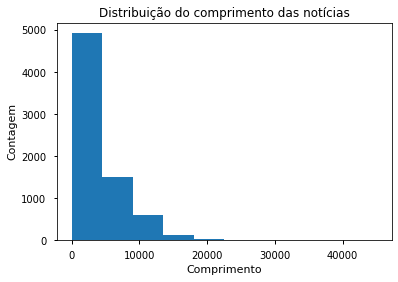

In [23]:
plt.hist(news_df.text_length)
plt.xlabel('Comprimento')
plt.ylabel('Contagem')
plt.title('Distribuição do comprimento das notícias')
plt.show()

In [24]:
news_df.text_length.describe()

count     7200.000000
mean      3777.382361
std       3952.549361
min         43.000000
25%        910.750000
50%       2108.000000
75%       5433.000000
max      44988.000000
Name: text_length, dtype: float64

*A maioria dos textos têm um comprimento pequeno (menos de 5 mil palavras), a partir disso decidimos averiguar a distribuição do comprimento entre notícias verdadeiras e falsas.*

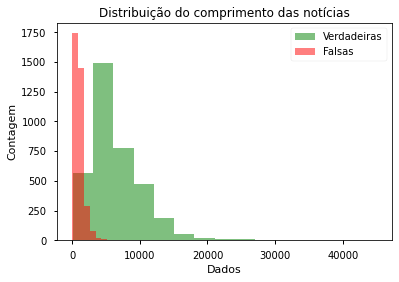

In [25]:
bins = 15
alpha = 0.5

plt.hist(news_df[news_df.label == 'true'].text_length,
         bins=bins,
         alpha=alpha,
         label='Verdadeiras',
         color='green')

plt.hist(news_df[news_df.label == 'fake'].text_length,
         bins=bins,
         alpha=alpha,
         label='Falsas',
         color='red')

plt.xlabel('Dados')
plt.ylabel('Contagem')
plt.title('Distribuição do comprimento das notícias')
plt.legend(loc='upper right')

plt.show()

*As notícias têm entre 46 e cerca de 46000 palavras, se distribuindo de maneira desigual de acordo com sua categoria. O comprimento das notícias verdadeiras tem tamanhos mais variados e mediana superior às notícias falsas, cujo comprimento se concentra numa faixa reduzida.* 

*Dentro desse conjunto de dados, notícias falsas tendem a ser mais curtas.*

#### Das palavras

- Há diferença no tamanho médio das palavras entre as diferentes categorias de notícias?

In [26]:
news_df['mean_word_len'] = (
    news_df['clean_text']
    .str
    .split()
    .apply(lambda text : [len(word) for word in text])
    .map(lambda word: np.mean(word))
)

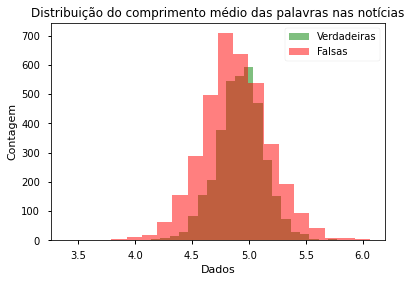

In [27]:
bins = 20
alpha = 0.5

plt.hist(news_df[news_df.label == 'true'].mean_word_len,
         bins=bins,
         alpha=alpha,
         label='Verdadeiras',
         color='green')

plt.hist(news_df[news_df.label == 'fake'].mean_word_len,
         bins=bins,
         alpha=alpha,
         label='Falsas',
         color='red')

plt.xlabel('Dados')
plt.ylabel('Contagem')
plt.title('Distribuição do comprimento médio das palavras nas notícias')
plt.legend(loc='upper right')

plt.show()

*Podemos observar um ligeiro deslocamento entre a média dos dados das notícias falsas e verdadeiras, apesar curva da distribuição se apresentar de maneira similar. Esta semelhança pode advir do fato de notícias de ambas categorias apresentarem a mesma temática e por tanto se utilizarem dos mesmos vocábulos.*

### Número de palavras

In [28]:
news_df['text_size'] = (
    news_df['clean_text']
    .str
    .split()
    .str
    .len()
)

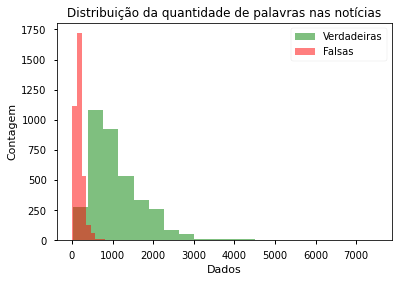

In [29]:
bins = 20
alpha = 0.5

plt.hist(news_df[news_df.label == 'true'].text_size,
         bins=bins,
         alpha=alpha,
         label='Verdadeiras',
         color='green')

plt.hist(news_df[news_df.label == 'fake'].text_size,
         bins=bins,
         alpha=alpha,
         label='Falsas',
         color='red')

plt.xlabel('Dados')
plt.ylabel('Contagem')
plt.title('Distribuição da quantidade de palavras nas notícias')
plt.legend(loc='upper right')

plt.show()

### Nuvens de palavras
- As palavras mais usadas nas notícias abordadas estão dentro dos mesmos campos semânticos?

In [30]:
nltk.download('stopwords')
stop = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to /home/tayna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


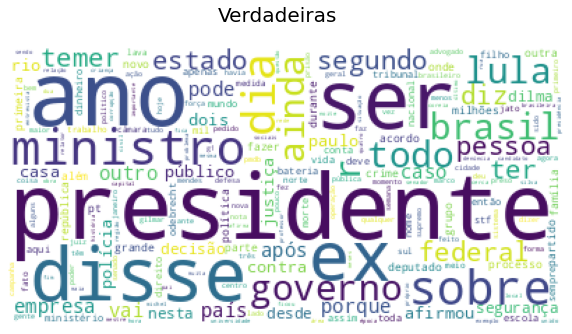

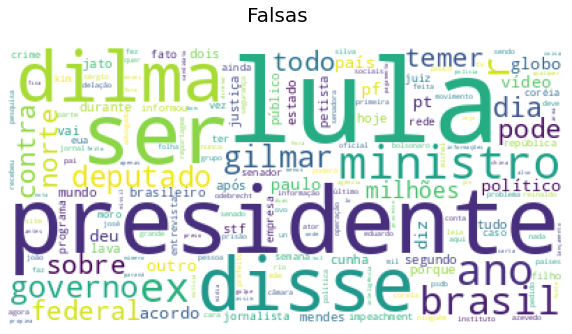

In [31]:
visualize.show_wordcloud(news_df[news_df.label == 'true'].clean_text[0:100], 
               stop, title = 'Verdadeiras')

visualize.show_wordcloud(news_df[news_df.label == 'fake'].clean_text[0:100], 
               stop, title = 'Falsas')

plt.show()

*Observamos que alguns vocábulos são bastante frequentes tanto em notícias falsas e verdadeiras, eles centram ao redor de cargos políticos("presidente"), figuras políticas("temer", "lula"), país("Brasil"). Alguns ainda são mais frequentes em notícias falsas, como as figuras políticas*

### N-gramas
- Em que contextos as palavras são usadas?

In [32]:
news_df['clean_text'] = news_df['clean_text'].apply(lambda c: process.remove_weekday(c))
#news_df['clean_clean_text']
news_df.sample(10)

,text,label,clean_text,text_length,mean_word_len,text_size
1938,Qual é o poder militar da Rússia e a quem ela ...,true,qual é o poder militar da rússia e a quem ela ...,8196,5.108048,1342
3338,A Polícia Federal apreendeu nas buscas feitas...,true,a polícia federal apreendeu nas buscas feitas...,6953,4.912415,1176
1986,Veja a repercussão na imprensa internacional d...,true,veja a repercussão na imprensa internacional d...,4718,4.943325,794
5728,Presidente dos EUA faz alerta à ONU e declara:...,fake,presidente dos eua faz alerta à onu e declara ...,808,4.905109,137
5800,Antagonista pega Lula de calças curtas e mostr...,fake,antagonista pega lula de calças curtas e mostr...,1575,4.794118,272
264,"A Primeira Turma do STF decidiu adiar, para d...",true,a primeira turma do stf decidiu adiar para da...,4580,4.971317,767
5399,"Renan coloca fim na palhaçada: ""É uma decisão ...",fake,renan coloca fim na palhaçada é uma decisão in...,657,5.646465,99
2461,A sessão de exorcismo de uma semana que termin...,true,a sessão de exorcismo de uma semana que termin...,14623,4.688059,2571
6637,Pedido de impeachment de Dilma é dado como cer...,fake,pedido de impeachment de dilma é dado como cer...,1635,4.822064,281
904,Comissão aprova projeto que prevê regras sobre...,true,comissão aprova projeto que prevê regras sobre...,7465,5.050243,1234


*Retiramos os dias da semana que estavam contaminando a visualização do bigrama.*

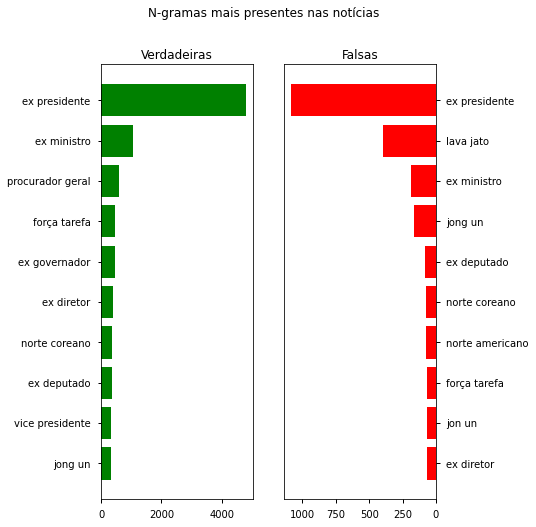

In [33]:
true_corpus = process.create_corpus(news_df[news_df.label == 'true'].clean_text)
fake_corpus = process.create_corpus(news_df[news_df.label == 'fake'].clean_text)

true_n_gram = process.get_top_ngram(corpus = true_corpus, n=2, top=10, stop_words=stop)
fake_n_gram = process.get_top_ngram(corpus = fake_corpus, n=2, top=10, stop_words=stop)

visualize.show_ngrams(true_n_gram, fake_n_gram)

*Podemos observar que em ambas as categorias, se faz referência a "ex presidente" e a ocupantes anteriores de cargos ("ex ministro", "ex deputado", "ex governador"), havendo também em ambas as notícias a menção de "norte-coreano" e a família jong-un.*

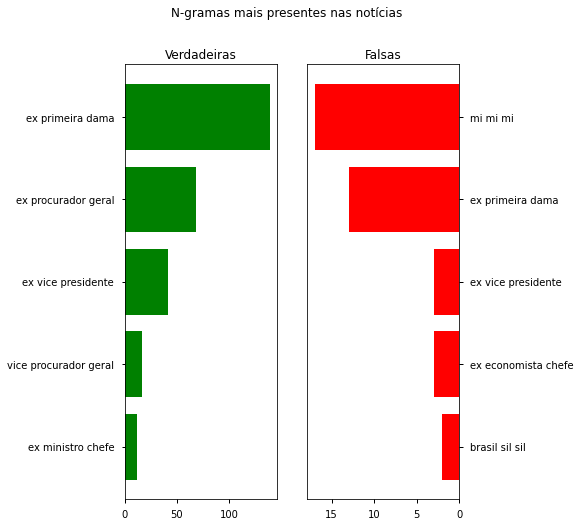

In [34]:
true_n_gram = process.get_top_ngram(corpus = true_corpus, n=3, top=5, stop_words=stop)
fake_n_gram = process.get_top_ngram(corpus = fake_corpus, n=3, top=5, stop_words=stop)

visualize.show_ngrams(true_n_gram, fake_n_gram)

Observamos também nas notícias falsas vocabulários informais('mi-mi-mi', 'brasil-sil-sil'), não ocorrendo nas notícias verdadeiras.

### Razão entre a proporção das palavras

- Quais palavras são mais comuns em notícias verdadeiras e, ao mesmo tempo, menos comuns em notícias falsas (e vice-versa)?

In [48]:
# Cria lista com todas as palavras de ambos os corpus
all_words = (set(true_corpus+fake_corpus))
all_words = [word for word in all_words if word not in stop]
len(all_words)

106556

In [71]:
# Pega proporção (em %) de cada palavra de cada corpus 
true_Counter = Counter(true_corpus)
true_part = [(i, true_Counter[i] / len(true_corpus) * 100.0) for i in true_Counter]
true_part = dict(true_part)

fake_Counter = Counter(fake_corpus)
fake_part =[(i, fake_Counter[i] / len(fake_corpus) * 100.0) for i in fake_Counter]
fake_part = dict(fake_part)

In [78]:
# Calcula a razão entre a proporção das palavras presentes em ambos os corpus
ratio_words = {}
for word in all_words:
    if word in true_part.keys():
        if word in fake_part.keys():
            ratio_words[word] = true_part[word]/fake_part[word]
    #     else:
    #         ratio_words[word] = float('inf')
    # else:
    #     ratio_words[word] = float('-inf')
#ratio_words

ratio_words = dict(sorted(ratio_words.items(), key=lambda item: item[1], reverse=True))

In [82]:
# Palavras mais comuns em notícias verdadeiras que em notícias falsas
dict(list(ratio_words.items())[0:10])

{'-': 81.83541024556482,
 'costamarques': 37.43794504520151,
 'play': 24.343058437462865,
 'procuradora-geral': 20.985395204709366,
 'diversidade': 19.47444674997029,
 'eldorado': 17.711673552774705,
 'concessões': 17.627731971955868,
 'ptb': 17.040140906224003,
 'estreia': 16.788316163767494,
 'demandas': 16.788316163767494}

In [83]:
# Palavras mais comuns em notícias falsas do que em notícias verdadeiras
dict(list(ratio_words.items())[-10:])

{'natasha': 0.015262105603424994,
 'boechat': 0.015262105603424992,
 'willian': 0.013990263469806245,
 'valdemiro': 0.012591237122825618,
 'vladmir': 0.011192210775844995,
 'kin': 0.010492697602354684,
 '767': 0.009326842313204164,
 'petralha': 0.008394158081883747,
 'ahhh': 0.006995131734903123,
 'coréia': 0.00577248693310057}